In [10]:
%matplotlib inline
import os, random, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.datasets as dset
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

from utils.constants import *
from utils.model import Generator, Discriminator
from utils.data import ImageTransform, MonetDataset, MonetDataModule
from utils.lightning import LightningSystem

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cpu


In [11]:
# Check input
transform = ImageTransform(img_size=256)
batch_size = 8

data_module = MonetDataModule(data_dir, transform, batch_size, phase='test')

dataloader = data_module.train_dataloader()
photo, style = next(iter(dataloader))

print(f'Photo Shape {photo.size()}')
print(f'Style Shape {style.size()}')

Photo Shape torch.Size([8, 3, 256, 256])
Style Shape torch.Size([8, 3, 256, 256])


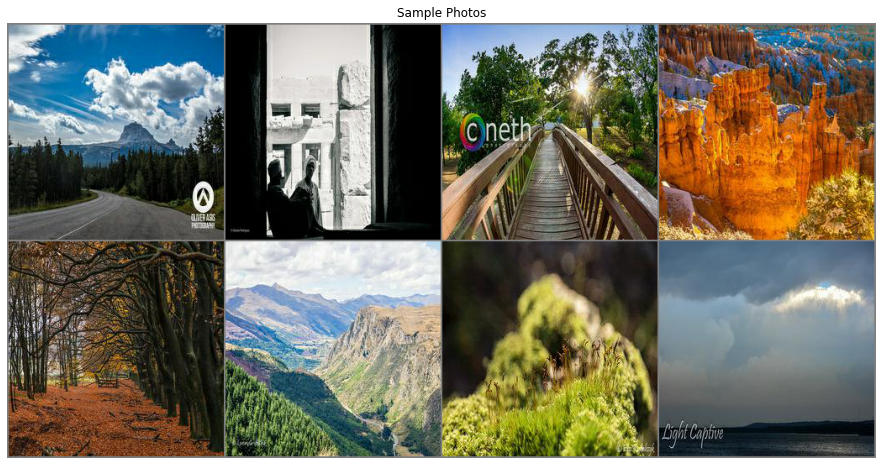

In [15]:
# display sample photos

grid = make_grid(photo, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
grid = 255 * (grid * 0.5 + 0.5)
grid = grid.astype(int)

plt.figure(figsize=(18, 8))
plt.imshow(grid)
plt.axis('off')
plt.title('Sample Photos')
plt.show()

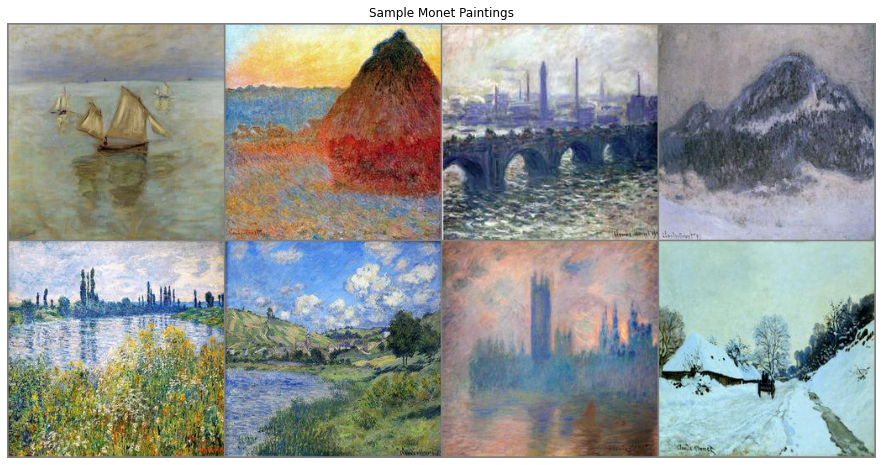

In [16]:
# show monet samples

grid = make_grid(style, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
grid = 255 * (grid * 0.5 + 0.5)
grid = grid.astype(int)

fig = plt.figure(figsize=(18, 8))
plt.imshow(grid)
plt.axis('off')
plt.title('Sample Monet Paintings')
plt.show()


In [17]:
# sanity check on models

net = Generator()
out = net(base)
print('Generator:', out.size())

net = Discriminator()
out = net(base)
print('Discriminator:', out.size())


Generator: torch.Size([8, 3, 256, 256])
Discriminator: torch.Size([8, 1, 30, 30])


In [27]:
def init_weights(net, init_gain=0.019):
    def init_func(m):  # define the initialization function
        class_name = m.__class__.__name__
        if hasattr(m, 'weight') and (class_name.find('Conv') != -1 or class_name.find('Linear') != -1):
            nn.init.normal_(m.weight.data, 0.0, init_gain)

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

        elif class_name.find('BatchNorm2d') != -1: 
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)

In [28]:
def do_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [31]:
# Config
seed = 42
reconstr_w = 10
id_w = 5

for i in range(30):
    do_seed(seed)
    data_module = MonetDataModule(data_dir, transform, batch_size, seed=seed)

    # initialize generators and discriminators
    G_base_to_style = Generator().to(device)
    init_weights(G_base_to_style)

    G_style_to_base = Generator().to(device)
    init_weights(G_style_to_base)

    D_base = Discriminator().to(device)
    init_weights(D_base)

    D_style = Discriminator().to(device)
    init_weights(D_style)

    model = LightningSystem(G_base_to_style, 
                            G_style_to_base, 
                            D_base, 
                            D_style, 
                            lr, 
                            transform, 
                            reconstr_w, 
                            id_w, 
                            num_epochs)

    if (os.path.exists('./saved_models/model')):
        print("Using previous model. Resuming training.")
        model.load_state_dict(torch.load('./saved_models/model'))

    print("Number of epochs:" + str(num_epochs))

    # Trainer
    trainer = Trainer(
        logger=False,
        max_epochs=num_epochs,
        gpus=ngpu,
        checkpoint_callback=False,
        reload_dataloaders_every_epoch=True,
        num_sanity_val_steps=0,
    )
    trainer.fit(model, datamodule=data_module)

    # save model params
    torch.save(model.state_dict(), './saved_models/model')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)
Losses log for CycleGAN

Number of epochs:1
Epoch 0:   0%|          | 0/38 [00:00<?, ?it/s] [0/1][0] 	Loss_val: 4.3718

[0/1][0] 	Loss_G: 11.4430

[0/1][0] 	Loss_val: 4.5825

[0/1][0] 	Loss_G: 11.6112

/Users/henrytrinh/Projects/gan-gogh/env/lib/python3.8/site-packages/pytorch_lightning/utilities/distr

In [23]:
do_seed(seed)

data_module = MonetDataModule(data_dir, transform, batch_size, seed=seed)

# initialize generators and discriminators
G_base_to_style = Generator().to(device)
init_weights(G_base_to_style)

G_style_to_base = Generator().to(device)
init_weights(G_style_to_base)

D_base = Discriminator().to(device)
init_weights(D_base)

D_style = Discriminator().to(device)
init_weights(D_style)

# Lightning
model = LightningSystem(G_base_to_style, 
                        G_style_to_base, 
                        D_base, 
                        D_style, 
                        lr, 
                        transform, 
                        reconstr_w, 
                        id_w, 
                        num_epochs)

if (os.path.exists('./saved_models/model')):
        print("Using previous model.")
        model.load_state_dict(torch.load('./saved_models/model'))

NameError: name 'seed' is not defined

In [20]:
# plot losses

figure, axes = plt.subplots(ncols=1, nrows=2, figsize=(18, 12), facecolor='w')
epoch_num = len(model.losses)

axes[1].plot(np.arange(epoch_num), model.identity, label='identity')
axes[1].plot(np.arange(epoch_num), model.reconstr, label='reconstr')
axes[1].plot(np.arange(epoch_num), model.validity, label='validity')

axes[1].legend()
axes[1].set_xlabel('Epoch #')

axes[0].plot(np.arange(epoch_num), model.losses, label='overall')
axes[0].plot(np.arange(epoch_num), model.D_mean_losses, label='discriminator')
axes[0].plot(np.arange(epoch_num), model.G_mean_losses, label='generator')

axes[0].legend()
axes[0].set_xlabel('Epoch #')

plt.show()

NameError: name 'model' is not defined

In [24]:
# generate photos with style

os.makedirs('./results', exist_ok=True)

net = model.G_basestyle
net.eval()

photo_imgs = glob(os.path.join(data_dir, 'photo', '*.jpg'))

for path in photo_imgs:
    img = transform(Image.open(path), phase='test')
    
    new = net(img.unsqueeze(0).to(device))[0]
    new = 255 * (new * 0.5 + 0.5)
    new = new.detach().cpu().numpy().astype(np.uint8)
    new = Image.fromarray(np.transpose(new, [1,2,0]))

    new.save(os.path.join('./results', path.split('/')[-1]))

KeyboardInterrupt: 